I want to compare some algorithms which are based on **decision tree algorithms**.
For comparison I took some popular libraries as **sklearn, mlpack**, etc. 

In [1]:
import pandas as pd
import numpy as np
from mlpack import decision_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
import time
import math
from matplotlib import pyplot as plt

I made comparison for **classification** implementations. 

For classification I take an example from mlpack [guide](https://www.mlpack.org/doc/mlpack-3.2.2/doxygen/python_quickstart.html)

In [2]:
def accuracy_fun(pred, test_labels):
    correct = np.sum(pred == np.reshape(test_labels, (test_labels.shape[0],)))
    correct_ratio = float(correct) / float(len(test_labels))
    return correct_ratio

## mlpack vs sklearn

In [3]:
df = pd.read_csv('http://www.mlpack.org/datasets/covertype-small.csv.gz')

y = df['label']
X = df.drop('label', 1)

In [4]:
parts_num:int = 5
part_size:int = math.ceil(X.shape[0]/parts_num)
folds_num:int = 10
KF = KFold(n_splits=folds_num, shuffle=True, random_state=42)

In [5]:
def cross_val(X, y):
    """
    Cross validation for data split. 
    Returns accuracy, fitting time and prediction time 
        for mlpack and sklearn implementations for each fold.
    """
    mlpack_accuracy = np.array([], dtype=float)
    sklearn_accuracy = np.array([], dtype=float)

    mlpack_fit_time = np.array([], dtype=float)
    mlpack_predict_time = np.array([], dtype=float)

    sklearn_fit_time = np.array([], dtype=float)
    sklearn_predict_time = np.array([], dtype=float)

    for train_index, test_index in KF.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # mlpack
        #fit
        start_time = time.time()
        est = decision_tree(training=X_train,
                                  labels=y_train, minimum_leaf_size = 1)
        end_time = time.time()
        mlpack_fit_time = np.append(mlpack_fit_time, (end_time-start_time))

        #predict
        dec_tree = est['output_model']
        start_time = time.time()
        output = decision_tree(input_model=dec_tree,
                                  test=X_test)
        end_time = time.time()
        mlpack_predict_time = np.append(mlpack_predict_time, (end_time-start_time))
        mlpack_accuracy = np.append(mlpack_accuracy, 
                                    accuracy_fun(output['predictions'], 
                                                 y_test))


        #sklearn
        #fit
        est = DecisionTreeClassifier()
        start_time = time.time()
        est = est.fit(X_train, y_train)
        end_time = time.time()
        sklearn_fit_time = np.append(sklearn_fit_time, (end_time-start_time))

        #predict
        start_time = time.time()
        prediction = est.predict(X_test)
        end_time = time.time()
        sklearn_predict_time = np.append(sklearn_predict_time, (end_time-start_time))
        sklearn_accuracy = np.append(sklearn_accuracy, accuracy_fun(
            prediction, y_test))
    return (mlpack_accuracy, 
            sklearn_accuracy, 
            mlpack_fit_time, 
            mlpack_predict_time,
            sklearn_fit_time,
            sklearn_predict_time)

Make cross valdation for dataset splits with different shapes.

In [6]:
run_res = dict()
shapes = [int(math.ceil((i+1)*X.shape[0]/parts_num)) for i in range(parts_num)]

for shape, i in zip(shapes, range(1, len(shapes)+1)):    
    X_current = X.iloc[0:shape]
    y_current = y.iloc[0:shape]
    (mlpack_accuracy, 
            sklearn_accuracy, 
            mlpack_fit_time, 
            mlpack_predict_time,
            sklearn_fit_time,
            sklearn_predict_time) = cross_val(X_current, y_current)
    run_res['mlpack_accuracy_{}'.format(i)] = mlpack_accuracy
    run_res['sklearn_accuracy_{}'.format(i)] = sklearn_accuracy
    run_res['mlpack_fit_time_{}'.format(i)] = mlpack_fit_time
    run_res['mlpack_predict_time_{}'.format(i)] = mlpack_predict_time
    run_res['sklearn_fit_time_{}'.format(i)] = sklearn_fit_time
    run_res['sklearn_predict_time_{}'.format(i)] = sklearn_predict_time

In [7]:
graphs_names=["accuracy", "fit_time", "predict_time"]
z = 1.96 # for 95% conf interval (coefficient)

Visualzation of results.
There are takes a confidence interval for accuracy in each dataset split point.

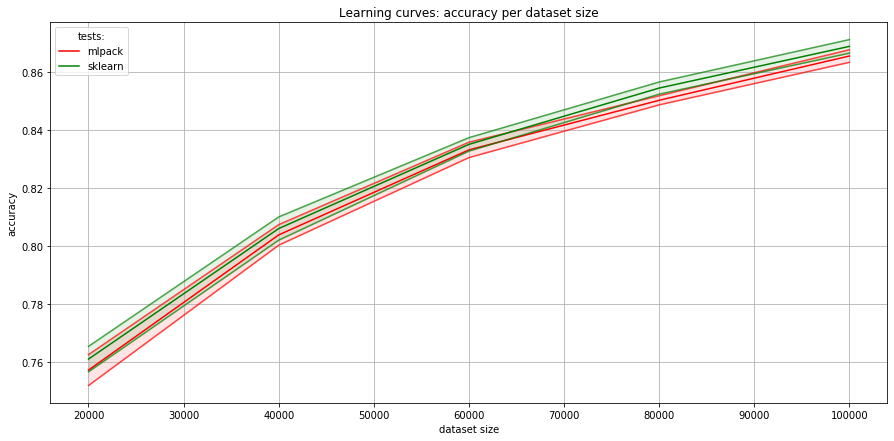

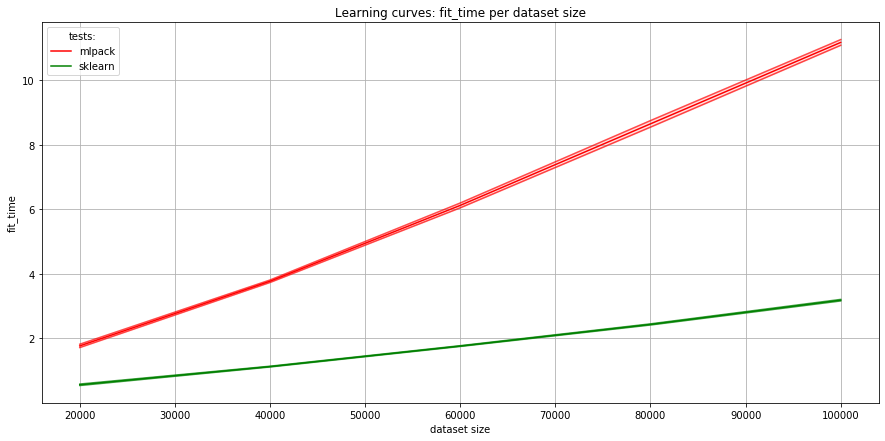

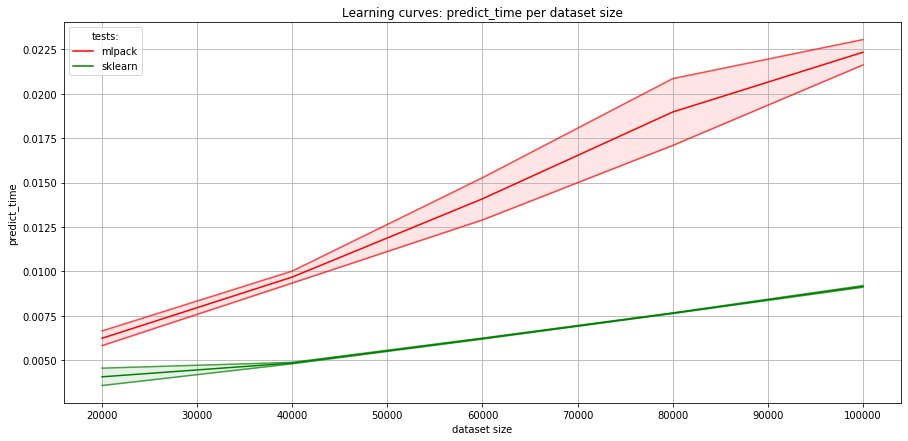

In [8]:
for name in graphs_names:
    mlpack_keys = [key for key in \
                   run_res.keys() if key.find("mlpack_"+name)!=-1]
    sklearn_keys = [key for key in \
                    run_res.keys() if key.find("sklearn_"+name)!=-1]
    mlpack_means  = np.array([np.mean(run_res[key]) for key in mlpack_keys])
    mlpack_std  = np.array([np.std(run_res[key]) for key in mlpack_keys])

    sklearn_means  = np.array([np.mean(run_res[key]) for key in sklearn_keys])
    sklearn_std  = np.array([np.std(run_res[key]) for key in sklearn_keys])
    
    #confidence interval values: 
    mlpack_std=(mlpack_std*z)/np.sqrt(folds_num) 
    sklearn_std=(sklearn_std*z)/np.sqrt(folds_num) 
    
    
    plt.figure(figsize=(15,7))
    plt.grid()

    #confidence interval for random:
    plt.plot(shapes, mlpack_means, color="r", label="mlpack")
    lower_mlpack=mlpack_means - mlpack_std
    upper_mlpack=mlpack_means + mlpack_std
    plt.plot(shapes, lower_mlpack, alpha=0.7, color="r")
    plt.plot(shapes, upper_mlpack, alpha=0.7, color="r")
    plt.fill_between(shapes, lower_mlpack, upper_mlpack, alpha=0.1, color="r") 

    plt.plot(shapes, sklearn_means, color="g", label="sklearn")
    lower_sklearn=sklearn_means - sklearn_std
    upper_sklearn=sklearn_means + sklearn_std
    plt.plot(shapes, lower_sklearn, alpha=0.7, color="g")
    plt.plot(shapes, upper_sklearn, alpha=0.7, color="g")
    plt.fill_between(shapes, lower_sklearn, upper_sklearn, alpha=0.1, color="g") 

    plt.legend(title='tests:')
    plt.title("Learning curves: {} per dataset size".format(name))
    plt.ylabel(name)
    plt.xlabel("dataset size")
    plt.savefig("data/{}.jpg".format(name))
    plt.show()